# Computing Collective Variables of the NTK

In this notebook we will walkthrough the computation of collective variables of the Neural Tangent Kernel (NTK) during training a model. 

### Imports

For calculating the NTK, we will exclusively be using the neural tangents library.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import znrnd
from neural_tangents import stax
import optax

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
jax.default_backend()

'cpu'

### Data generators

For the sake of covereage, we will look at the NTK properties of the Fuel data set for a small model.

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')


dataset = (dataset-dataset.mean())/dataset.std()

class MPGDataGenerator(znrnd.data.DataGenerator):
    """
    Data generator for the MPG dataset.
    """
    def __init__(self, dataset: pd.DataFrame):
        """
        Constructor for the data generator.
        
        Parameters
        ----------
        dataset
        """        
        train_ds = dataset.sample(frac=0.8, random_state=0)
        train_labels = train_ds.pop("MPG")
        test_ds = dataset.drop(train_ds.index)
        test_labels = test_ds.pop("MPG")
        
        self.train_ds = {"inputs": train_ds.to_numpy(), "targets": train_labels.to_numpy().reshape(-1, 1)}
        self.test_ds = {"inputs": test_ds.to_numpy(), "targets": test_labels.to_numpy().reshape(-1, 1)}
        
        self.data_pool = self.train_ds["inputs"]


In [4]:
data_generator = MPGDataGenerator(dataset)

###  Networks and Models

Now we can define the network architectures for which we will compute the NTK of the data.

The batch size defined in the model class refers to the batching in the NTK calculation. When calculating the NTK, the number of data points used in that calculation must be an integer mutliple of the batch size. 

In [5]:
dense_network = stax.serial(
    stax.Dense(32),
    stax.Relu(),
    stax.Dense(32),
)

In [6]:
fuel_model = znrnd.models.NTModel(
    nt_module=dense_network,
    optimizer=optax.adam(learning_rate=0.005),
    input_shape=(9,),
    batch_size=314
)

### Recording 

Using a recorder we can track the NTK and its properties while training a model. 
Defining a recorder, we can decide which properties to track. 
We will calculate 
- Loss
- Accuracy
- NTK
- Entropy of the NTK
- Trace of the NTK
- Frobenius norm of the Loss Derivative

of the train data and the Loss and Accuracy of the test data. 

In [7]:
train_recorder = znrnd.training_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    ntk=True,
    entropy= True, 
    trace=True,
    loss_derivative=True,
    update_rate=1
)
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)


test_recorder = znrnd.training_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    update_rate=1
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

### Training strategy 

In order to train, we need a training strategy, which will use the defined recorders. 

In [8]:
training_strategy = znrnd.training_strategies.SimpleTraining(
    model=fuel_model, 
    loss_fn=znrnd.loss_functions.LPNormLoss(order=2),
    recorders=[train_recorder, test_recorder],
)

### Training

Now we train the model

In [9]:
batched_training_metrics = training_strategy.train_model(
    train_ds=data_generator.train_ds, 
    test_ds=data_generator.test_ds,
    batch_size=32,
)

Epoch: 50: 100%|█████████████████████████████████| 50/50 [00:14<00:00,  3.36batch/s, test_loss=1.44]


## Checking the Results

Now let's use the export function of the reporter to get access to an easy to plot dataclass with all of the metrics we recorded.

In [10]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

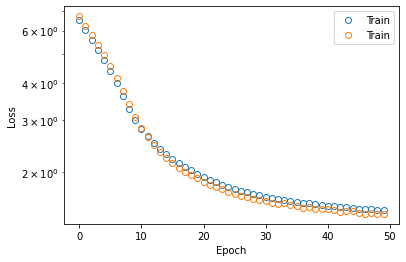

In [11]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(test_report.loss, 'o', mfc='None', label="Train")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

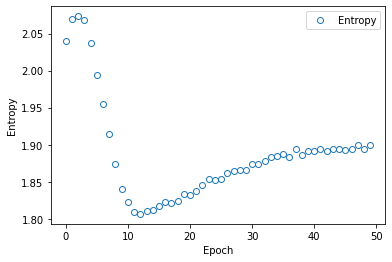

In [12]:
plt.plot(train_report.entropy, 'o', mfc='None', label="Entropy")
plt.xlabel("Epoch")
plt.ylabel("Entropy")
plt.legend()
plt.show()

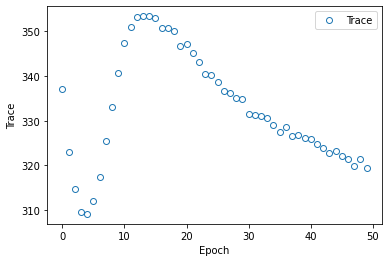

In [13]:
plt.plot(train_report.trace, 'o', mfc='None', label="Trace")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.legend()
plt.show()

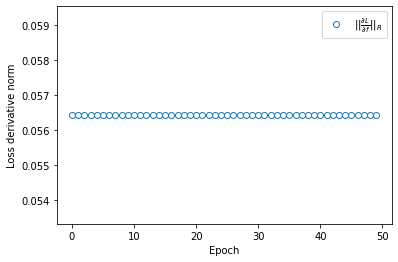

In [14]:
plt.plot(
    train_report.loss_derivative, 
    'o', 
    mfc='None', 
    label=r"$|| \frac{\partial L }{ \partial f}||_R$"
)
plt.xlabel("Epoch")
plt.ylabel("Loss derivative norm")
plt.legend()
plt.show()